In [2]:
import json
import statistics as s
import pandas as pd

In [6]:
with open("results/mlp_test.json", 'r') as f:
    results = json.load(f)

print(f"Num samples: {len(results['time_s'])}")
print(f"Mean Plain: {s.mean(results['time_p'])}")
print(f"Stdev plain: {s.stdev(results['time_p'])}")
print(f"Mean SMPC: {s.mean(results['time_s'])}")
print(f"Stdev SMPC: {s.stdev(results['time_s'])}")

Num samples: 1000
Mean Plain: 0.0053945469856262205
Std plain: 0.0007231878607665458
Mean SMPC: 0.03550816035270691
Std SMPC: 0.005474169769276747


In [12]:
with open("results/cnn_mlp_small.json", 'r') as f:
    results = json.load(f)
df = pd.DataFrame(results)
df['input_shape'] = df['input_shape'].apply(str)
df['model_config'] = df['model_config'].apply(lambda x: f"{len(x)}x{x[0]}")
result = df.groupby(['type', 'input_shape'])['num_params'].agg(['mean', 'std']).reset_index()
print(result)

  type       input_shape      mean            std
0  CNN  [1, 128, 128, 3]   33951.2   28129.228983
1  CNN    [1, 32, 32, 3]   33951.2   28129.228983
2  CNN    [1, 64, 64, 3]   33951.2   28129.228983
3  MLP         [1, 1024]  236889.6  195598.395282
4  MLP          [1, 128]   59123.2   31424.795102
5  MLP          [1, 512]  135308.8   97321.868885


In [13]:
grouped = df.groupby(['type', 'input_shape'])

# Get indices of max and min num_params
max_params_idx = grouped['num_params'].idxmax()
min_params_idx = grouped['num_params'].idxmin()

# Create result DataFrame
result = pd.DataFrame({
    'type': grouped['num_params'].agg(lambda x: x.index[0]).reset_index()['type'],
    'input_shape': grouped['num_params'].agg(lambda x: x.index[0]).reset_index()['input_shape'],
    'max_num_params': grouped['num_params'].max().reset_index()['num_params'],
    'max_model_config': df.loc[max_params_idx, 'model_config'].reset_index(drop=True),
    'min_num_params': grouped['num_params'].min().reset_index()['num_params'],
    'min_model_config': df.loc[min_params_idx, 'model_config'].reset_index(drop=True)
})

# Display the result
print(result)

  type       input_shape  max_num_params max_model_config  min_num_params  \
0  CNN  [1, 128, 128, 3]           76096             3x64            6916   
1  CNN    [1, 32, 32, 3]           76096             3x64            6916   
2  CNN    [1, 64, 64, 3]           76096             3x64            6916   
3  MLP         [1, 1024]          529408            1x512           48448   
4  MLP          [1, 128]          100864            2x256           19776   
5  MLP          [1, 512]          267264            1x512           32064   

  min_model_config  
0             48x4  
1             48x4  
2             48x4  
3            16x32  
4            16x32  
5            16x32  


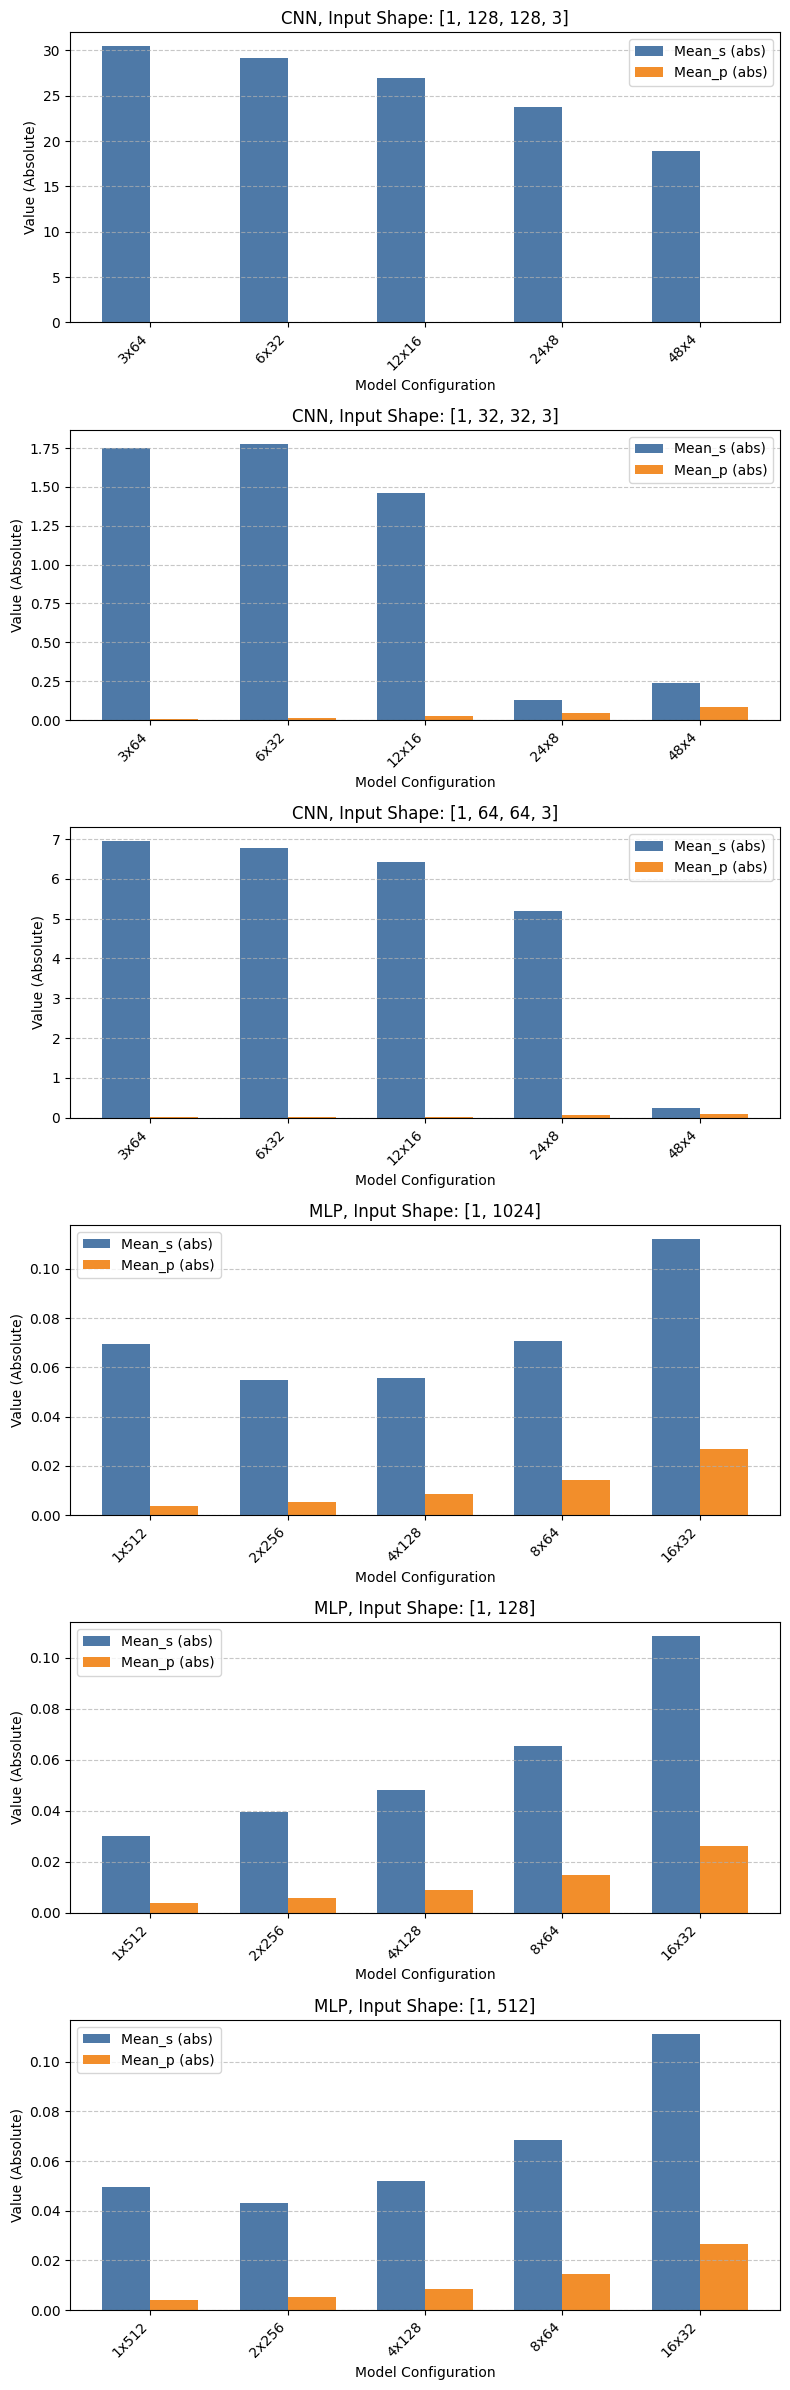

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# Convert model_config to string for labels
df['model_config_str'] = df['model_config'].apply(lambda x: x)

# Convert mean_p and mean_s to positive
df['mean_p_abs'] = df['mean_p'].abs()
df['mean_s_abs'] = df['mean_s'].abs()

# Group by type and input_shape
groups = df.groupby(['type', 'input_shape'])

# Create subplots for each group
fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(8, 4 * len(groups)), sharex=False)
if len(groups) == 1:
    axes = [axes]  # Ensure axes is a list for single group

# Plot grouped bar chart for each group
for ax, (group_name, group_data) in zip(axes, groups):
    model_configs = group_data['model_config_str']
    mean_s = group_data['mean_s_abs']
    mean_p = group_data['mean_p_abs']
    
    # Set bar positions
    x = np.arange(len(model_configs))
    width = 0.35  # Width of bars
    
    # Plot bars
    ax.bar(x - width/2, mean_s, width, label='Mean_s (abs)', color='#4e79a7')
    ax.bar(x + width/2, mean_p, width, label='Mean_p (abs)', color='#f28e2b')
    
    # Customize plot
    ax.set_xlabel('Model Configuration')
    ax.set_ylabel('Value (Absolute)')
    ax.set_title(f'{group_name[0]}, Input Shape: {group_name[1]}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_configs, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [16]:
grouped = df.groupby('type')

# Compute max and min stdev_p and stdev_s with corresponding model_config
result = pd.DataFrame({
    'type': grouped['stdev_p'].agg(lambda x: x.index[0]).reset_index()['type'],
    'max_stdev_p': grouped['stdev_p'].max().reset_index()['stdev_p'],
    'max_stdev_p_config': df.loc[grouped['stdev_p'].idxmax(), 'model_config_str'].reset_index(drop=True),
    'min_stdev_p': grouped['stdev_p'].min().reset_index()['stdev_p'],
    'min_stdev_p_config': df.loc[grouped['stdev_p'].idxmin(), 'model_config_str'].reset_index(drop=True),
    'max_stdev_s': grouped['stdev_s'].max().reset_index()['stdev_s'],
    'max_stdev_s_config': df.loc[grouped['stdev_s'].idxmax(), 'model_config_str'].reset_index(drop=True),
    'min_stdev_s': grouped['stdev_s'].min().reset_index()['stdev_s'],
    'min_stdev_s_config': df.loc[grouped['stdev_s'].idxmin(), 'model_config_str'].reset_index(drop=True)
})

# Display the result
print("Max and Min Standard Deviations by Type:")
print(result)


Max and Min Standard Deviations by Type:
  type  max_stdev_p max_stdev_p_config   min_stdev_p min_stdev_p_config  \
0  CNN     0.025914               24x8  1.685874e-07               3x64   
1  MLP     0.001069              16x32  2.528811e-06              1x512   

   max_stdev_s max_stdev_s_config  min_stdev_s min_stdev_s_config  
0     0.139159               3x64     0.002624               6x32  
1     0.027036              16x32     0.001776              1x512  
